In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.colors as mcolors

from tqdm.notebook import tqdm

In [6]:
rng = np.random.RandomState(seed=1)
m1 = np.load('../matrices/2024_FULL-STACK.npy')
m2 = np.load('../matrices/DOWNSAMPLED-FULL-STACK.npy')
X = np.random.choice(m1[m1!=0.0].flatten(), (100000,1))

In [7]:
k_arr = np.arange(10) + 1
models = [
    GaussianMixture(n_components=k).fit(X)
    for k in k_arr
]

In [8]:
# Plot function
def plot_mixture(gmm, X, show_legend=True, ax=None):
    if ax is None:
        ax = plt.gca()

    # Compute PDF of whole mixture
    x = np.linspace(8000, 14000, 5000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)

    # Compute PDF for each component
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    # Plot data histogram
    ax.hist(X, 1000, density=True, histtype='stepfilled', alpha=0.4, label ='Data')

    # Plot PDF of whole model
    ax.plot(x, pdf, '-k', label='Mixture PDF')
    
    # Plot PDF of each component
    ax.plot(x, pdf_individual, '--', label='Component PDF')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    if show_legend:
        ax.legend()

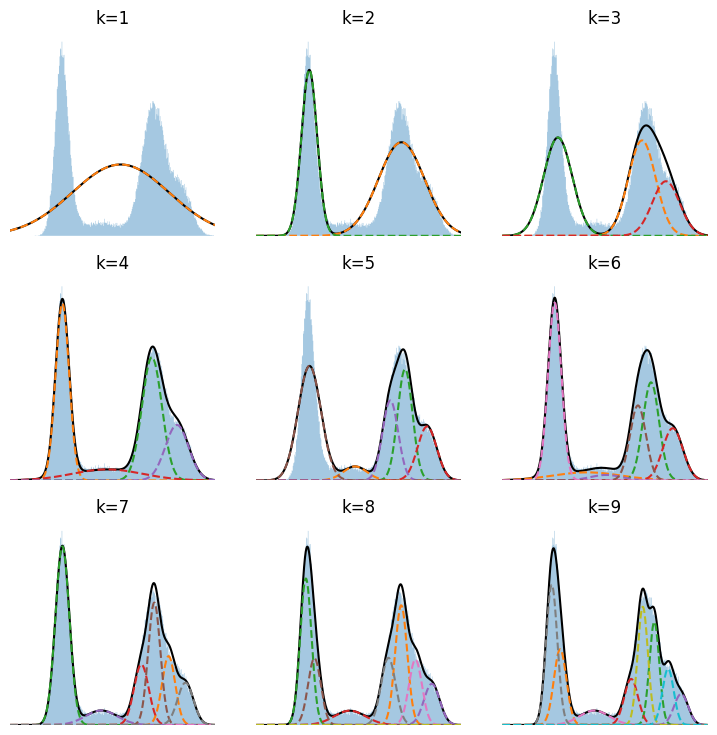

In [10]:
# Show all models for n_components 1 to 9
_, axes = plt.subplots(3,3,figsize=np.array([3,3])*3, dpi=100)
for gmm, ax in zip(models, axes.ravel()):
    plot_mixture(gmm, X, show_legend=False, ax=ax)
    ax.set_title(f'k={gmm.n_components}')
    ax.set_xlim(9000, 13000)
    ax.axis('off')
plt.tight_layout
plt.show()

In [6]:
model = models[4]

In [7]:
m = model.means_
w = model.weights_
cov = model.covariances_

In [8]:
print(m)
print(w)
print(cov)

[[10019.69581148]
 [11893.44039962]
 [10868.12675461]
 [12323.64763356]
 [11628.95113612]]
[0.34188745 0.23825396 0.11377356 0.14917949 0.15690554]
[[[ 16934.99383755]]

 [[ 23053.67418519]]

 [[462921.63692205]]

 [[ 38322.06376821]]

 [[ 22057.39022366]]]


(0.0, 1.0, 1.0)
(0.2, 0.8, 1.0)
(0.4, 0.6, 1.0)
(0.6000000000000001, 0.3999999999999999, 1.0)
(0.8, 0.19999999999999996, 1.0)


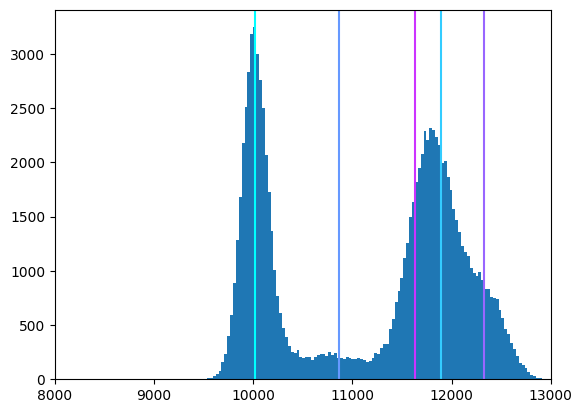

In [9]:
plt.hist(X, 500)

i=0
for mean in m:
    col = (i*0.2, 1-i*0.2, 1.0)
    plt.axvline(mean, color=col)
    print(col)
    i+=1

plt.xlim(8000,13000)
plt.show()

In [10]:
def normal(x, mean, weight, variance):
    std = np.sqrt(variance)
    denom = std*np.sqrt(2*np.pi)
    y = 1/(denom)*np.exp(-0.5*((x-mean)/std)**2)
    #y = y/np.max(y)
    return (weight*y).flatten()

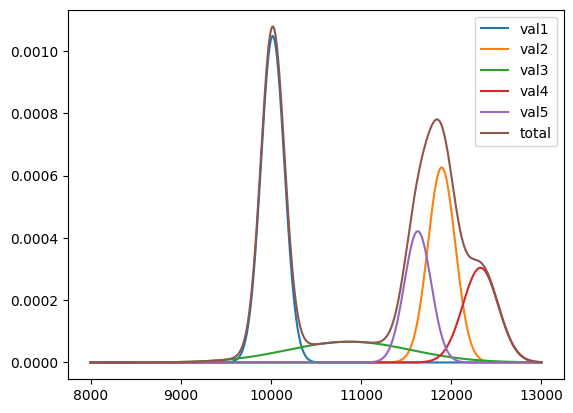

838779.9472698481


In [11]:
xs = np.linspace(8000, 13000, 1000).flatten()
tests = []
m = m.flatten()
w = w.flatten()
cov = cov.flatten()

i=0
for _ in m:
    vals = normal(xs, m[i], w[i], cov[i])
    tests.append(vals)
    i+=1

for plot in tests:
    plt.plot(xs, plot)

total = np.zeros(1000)
for test in tests:
    total += np.asarray(test)

plt.plot(xs, total)
plt.legend(["val1", "val2", "val3", "val4", "val5", "total"])
plt.show()

print(255*1/np.max(tests[3]))

[10846.58625967 11902.16195325 12328.81079887 10019.66152598 11626.72329618]

[0.11137379 0.23779421 0.14601426 0.34330841 0.16150933]

[442930.66825418 21993.81089889 35666.10019215 17127.77443299 20615.97445185]

In [20]:
from numba import njit

# Modified to temporarily remove weight.
# Return to normal by adding weight parameter, multiply return by weight.
@njit
def normal(x, mean, variance):
    std = np.sqrt(variance)
    denom = std*2.5066283
    y = 1/(denom)*np.exp(-0.5*((x-mean)/std)**2)
    return y

@njit
def model(x):
    probabilities = np.array([normal(x, 12328.81079887, 35666.10019215)/0.002112429621785987*255,
                              normal(x, 11902.16195325, 21993.81089889)/0.0026900466908721956*255,
                              normal(x, 11626.72329618, 20615.97445185)/0.0027784854556258715*255,
                              normal(x, 10846.58625967, 442930.66825418)/0.0005994351222135345*255,
                              normal(x, 10019.66152598, 17127.77443299)/0.0030483132513914597*255], dtype=np.uint8)
    """probabilities = np.array([normal(x, 12328.81079887, 0.14601426, 35666.10019215)*243706,
                              normal(x, 11902.16195325, 0.23779421, 21993.81089889)*243706,
                              normal(x, 11626.72329618, 0.16150933, 20615.97445185)*243706,
                              normal(x, 10846.58625967, 0.11137379, 442930.66825418)*243706,
                              normal(x, 10019.66152598, 0.34330841, 17127.77443299)*243706], dtype=np.uint8)"""
    return probabilities

predictions = []
xs = np.linspace(8000,13000,500)
for x in xs:
    predictions.append(model(x))

pred = np.asarray(predictions).reshape((500,5))
    

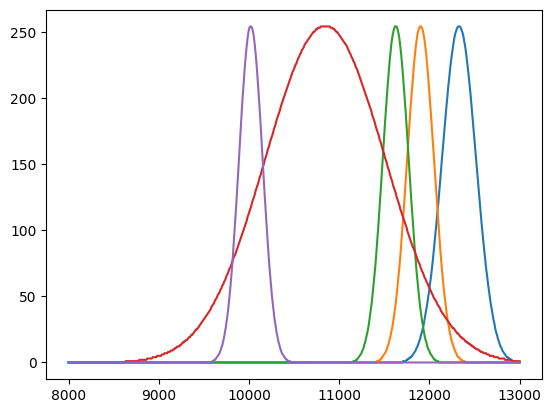

In [21]:
pred = np.asarray(predictions)
plt.plot(xs, pred)
plt.show()

In [22]:
plc = np.zeros((542,542,894,5), dtype=np.uint8)
with tqdm(total=542) as pbar:
    for i in range(m2.shape[0]):
        for j in range(m2.shape[1]):
            for k in range(m2.shape[2]):
                plc[i,j,k,:] = model(m2[i,j,k])
        pbar.update(1)

  0%|          | 0/542 [00:00<?, ?it/s]

In [23]:
np.save("../matrices/segmentation/downsampled-normal-probabilities.npy", plc)

In [24]:
m2.shape

(542, 542, 894)

In [25]:
plc = np.zeros((1084//2, 1084//2), dtype=np.uint8)
for i in range(1084//2):
    for j in range(1084//2):
        mod = model(m2[i,j,400])
        plc[i,j] = np.argmax(mod)

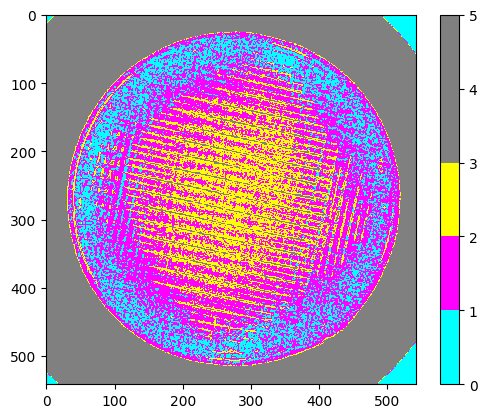

In [27]:
test = (plc<=4)*plc
cmap, norm = mcolors.from_levels_and_colors([0,1,2,3,4,5], ['cyan','magenta','yellow','gray','gray'])
plt.imshow(test, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [52]:
mod = model(11436)
ind = np.argmax(mod)
print(mod)
print(np.max(mod))

[0.001054295923985756, 1.1151478702130322, 45.261774871349715, 10.991930860198817, 9.423278502402234e-24]
45.261774871349715


In [4]:
print(3*np.sqrt(35666.10019215))
print(3*np.sqrt(21993.81089889))
print(3*np.sqrt(20615.97445185))
print(3*np.sqrt(442930.66825418))
print(3*np.sqrt(17127.77443299))

#12328.81079887
#11902.16195325
#11626.72329618
#10846.58625967
#10019.66152598

566.5641196981592
444.90931445633953
430.74791939909585
1996.5910984194084
392.6193702517873
